In [2]:
# %load NX01_master.py
#!/usr/bin/env python

"""
Created by stevertaylor
Copyright (c) 2014 Stephen R. Taylor

Code contributions by Rutger van Haasteren (piccard) and Justin Ellis (PAL/PAL2).

"""

import os, math, optparse, time, cProfile
from time import gmtime, strftime
from collections import OrderedDict
import h5py as h5

import numpy as np
from numpy import *

from scipy import integrate
from scipy import optimize
from scipy import constants
from numpy import random
from scipy import special as ss
from scipy import linalg as sl

import numexpr as ne
import ephem
from ephem import *

import libstempo as T2

import NX01_AnisCoefficients as anis
import NX01_utils as utils
import NX01_psr

import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True)

import NX01_jitter as jitter

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

/Users/staylor/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [13]:
from_h5 = True
psrlist = './PsrListings.txt'
nmodes = 15
dmVar = False
ptmcmc = True
num_gwfreq_wins = 1
LMAX = 0
use_gpu = False
fix_slope = True
limit_or_detect_gwb = True
limit_or_detect_red = True
anis_modefile = None
fullN = True

In [4]:
'''
parser = optparse.OptionParser(description = 'NX01 - Precursor to the PANTHER Group ENTERPRISE project')

############################
############################

parser.add_option('--from-h5', dest='from_h5', action='store_true', default = False,
                   help='Do you want to read in pulsars from hdf5 files instead of directly via libstempo? (default = False)')
parser.add_option('--psrlist', dest='psrlist', action='store', type=str, default = None,
                   help='Provide path to file containing list of pulsars and their respective par/tim paths')
parser.add_option('--nmodes', dest='nmodes', action='store', type=int,
                   help='Number of modes in low-rank time-frequency approximation')
parser.add_option('--dmVar', dest='dmVar', action='store_true', default=False,
                   help='Search for DM variations in the data (False)? (default=False)')
parser.add_option('--ptmcmc', dest='ptmcmc', action='store_true', default=True,
                   help='Sample using PALs parallel tempering MCMC (False)? (default=True)')
parser.add_option('--num_gwfreq_wins', dest='num_gwfreq_wins', action='store', type=int, default=1,
                   help='Number windows to split the band into (useful for evolving anisotropic searches (default = 1 windows)')
parser.add_option('--lmax', dest='LMAX', action='store', type=int, default=0,
                   help='Maximum multipole in anisotropic search (default = 0, i.e. isotropic-search)')
parser.add_option('--use-gpu', dest='use_gpu', action='store_true', default=False,
                  help='Do you want to use the GPU for accelerated linear algebra? (default = False)')
parser.add_option('--fix-slope', dest='fix_slope', action='store_true', default=False,
                  help='Do you want to fix the slope of the GWB spectrum? (default = False)')
parser.add_option('--limit-or-detect-gwb', dest='limit_or_detect_gwb', action='store', type=str, default='limit',
                   help='Do you want to use a uniform prior on log_10(Agwb) [detect] or Agwb itself [upper-limit] (default=\'limit\')?')
parser.add_option('--limit-or-detect-red', dest='limit_or_detect_red', action='store', type=str, default='limit',
                   help='Do you want to use a uniform prior on log_10(Ared) [detect] or Ared itself [upper-limit] (default=\'limit\')?')
parser.add_option('--anis-modefile', dest='anis_modefile', action='store', type=str, default = None,
                   help='Do you want to provide an anisotropy modefile to split band into frequency windows?')
parser.add_option('--fullN', dest='fullN', action='store_true', default=True,
                  help='Do you want to perform a full noise search? (default = True)')

(args, x) = parser.parse_args()
'''

"\nparser = optparse.OptionParser(description = 'NX01 - Precursor to the PANTHER Group ENTERPRISE project')\n\n############################\n############################\n\nparser.add_option('--from-h5', dest='from_h5', action='store_true', default = False,\n                   help='Do you want to read in pulsars from hdf5 files instead of directly via libstempo? (default = False)')\nparser.add_option('--psrlist', dest='psrlist', action='store', type=str, default = None,\n                   help='Provide path to file containing list of pulsars and their respective par/tim paths')\nparser.add_option('--nmodes', dest='nmodes', action='store', type=int,\n                   help='Number of modes in low-rank time-frequency approximation')\nparser.add_option('--dmVar', dest='dmVar', action='store_true', default=False,\n                   help='Search for DM variations in the data (False)? (default=False)')\nparser.add_option('--ptmcmc', dest='ptmcmc', action='store_true', default=True,\n    

In [5]:
# Do you want to use GPU acceleration?
if use_gpu:
    import pycuda.autoinit
    from pycuda.compiler import SourceModule
    import pycuda.gpuarray as gpuarray
    import pycuda.driver as drv
    import pycuda.elementwise as el
    import pycuda.tools as tools
    import scikits.cuda.linalg as culinalg
    import scikits.cuda.misc as cumisc

    culinalg.init()

In [6]:
if nmodes:
    print "\n You've given me the number of frequencies to include in the low-rank time-frequency approximation, got it?\n"
else:
    print "\n You've given me the sampling cadence for the observations, which determines the upper frequency limit and the number of modes, got it?\n"

if ptmcmc:
    import PALInferencePTMCMC as PAL
else:
    import pymultinest

#parser = optparse.OptionParser(description = 'NX01 - Precursor to the PANTHER Group ENTERPRISE project')


 You've given me the number of frequencies to include in the low-rank time-frequency approximation, got it?



In [275]:
################################################################################################################################
# PASSING THROUGH TEMPO2 VIA libstempo
################################################################################################################################

psr_pathinfo = np.genfromtxt(psrlist, dtype=str, skip_header=2) # name, hdf5-path, par-path, tim-path

if from_h5:

    tmp_psr = []
    for ii,tmp_name in enumerate(psr_pathinfo[:10,0]):
        tmp_psr.append(h5.File(psr_pathinfo[ii,1], 'r')[tmp_name])

    psr = [NX01_psr.PsrObjFromH5(p) for p in tmp_psr]
    
else:
    
    t2psr=[]
    for ii in range(len(psr_pathinfo)):
        t2psr.append( T2.tempopulsar( parfile=psr_pathinfo[ii,2], timfile=psr_pathinfo[ii,3] ) )
        t2psr[ii].fit(iters=3)
        if np.any(np.isfinite(t2psr.residuals())==False)==True:
            t2psr = T2.tempopulsar( parfile=psr_pathinfo[ii,2], timfile=psr_pathinfo[ii,3] )

    psr = [NX01_psr.PsrObj(p) for p in t2psr]


# Grab all the pulsar quantities
[p.grab_all_vars() for p in psr]

# Now, grab the positions and compute the ORF basis functions
psr_positions = [np.array([psr[ii].psr_locs[0],
                           np.pi/2. - psr[ii].psr_locs[1]])
                           for ii in range(len(psr))]
positions = np.array(psr_positions).copy()

--> Extracting J1713+0747 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1909-3744 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1640+2224 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1600-3053 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J2317+1439 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1918-0642 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1744-1134 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0030+0451 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0613-0200 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1614-2230 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 



In [276]:
CorrCoeff = np.array(anis.CorrBasis(positions,LMAX))       # Computing all the correlation basis-functions for the array.
harm_sky_vals = utils.SetupPriorSkyGrid(LMAX)              # Computing the values of the spherical-harmonics up to order
                                                                # LMAX on a pre-specified grid

In [277]:
                                                            
if anis_modefile is None:
    gwfreqs_per_win = int(1.*nmodes/(1.*num_gwfreq_wins)) # getting the number of GW frequencies per window
    anis_modefreqs = np.arange(1,nmodes+1)
    anis_modefreqs = np.reshape(anis_modefreqs, (num_gwfreq_wins,gwfreqs_per_win))

    tmp_num_gwfreq_wins = num_gwfreq_wins
else:
    tmp_modefreqs = np.loadtxt(anis_modefile)
    tmp_num_gwfreq_wins = tmp_modefreqs.shape[0]
    anis_modefreqs = []
    for ii in range(tmp_num_gwfreq_wins):
        anis_modefreqs.append(np.arange(tmp_modefreqs[ii,0],tmp_modefreqs[ii,1]+1))

# Create a tag for evolving anisotropy searches
if (LMAX!=0) and (tmp_num_gwfreq_wins > 1):
    evol_anis_tag = 'EvAnis'
else:
    evol_anis_tag = ''

In [278]:
              
#############################################################################
# GETTING MAXIMUM TIME, COMPUTING FOURIER DESIGN MATRICES, AND GETTING MODES 
#############################################################################

Tmax = np.max([p.toas.max() - p.toas.min() for p in psr])

if nmodes:

    [p.makeTe(nmodes, Tmax, makeDM=dmVar) for p in psr]
    # get GW frequencies
    fqs = np.linspace(1/Tmax, nmodes/Tmax, nmodes)
    nmode = nmodes

else:

    nmode = int(round(Tmax/cadence))
    [p.makeTe(nmode, Tmax, makeDM=dmVar) for p in psr]
    # get GW frequencies
    fqs = np.linspace(1/Tmax, nmode/Tmax, nmode)

In [279]:
#######################################
# PRE-COMPUTING WHITE NOISE PROPERTIES 
#######################################

loglike1 = 0
TtNT = []
d = []
for ii,p in enumerate(psr):

    # compute ( T.T * N^-1 * T ) & log determinant of N
    new_err = (p.toaerrs).copy()
    if fullN==True:
        
        if len(p.ecorrs)>0:
            print 'ok'
            Jamp = np.ones(len(p.epflags))
            for jj,nano_sysname in enumerate(p.sysflagdict['nano-f'].keys()):
                Jamp[np.where(p.epflags==nano_sysname)] *= p.ecorrs[nano_sysname]**2.0

            Nx = jitter.cython_block_shermor_0D(p.res, new_err**2., Jamp, p.Uinds)
            d.append(np.dot(p.Te.T, Nx))
            logdet_N, TtNT_dummy = jitter.cython_block_shermor_2D(p.Te, new_err**2., Jamp, p.Uinds)
            TtNT.append(TtNT_dummy)
            det_dummy, dtNdt = jitter.cython_block_shermor_1D(p.res, new_err**2., Jamp, p.Uinds)

        else:
            
            d.append(np.dot(p.Te.T, p.res/( new_err**2.0 )))
        
            N = 1./( new_err**2.0 )
            right = (N*p.Te.T).T
            TtNT.append(np.dot(p.Te.T, right))
    
            logdet_N = np.sum(np.log( new_err**2.0 ))
        
            # triple product in likelihood function
            dtNdt = np.sum(p.res**2.0/( new_err**2.0 ))
        
    else:

        d.append(np.dot(p.Te.T, p.res/( new_err**2.0 )))
            
        N = 1./( new_err**2.0 )
        right = (N*p.Te.T).T
        TtNT.append(np.dot(p.Te.T, right))

        logdet_N = np.sum(np.log( new_err**2.0 ))
        
        # triple product in likelihood function
        dtNdt = np.sum(p.res**2.0/( new_err**2.0 ))

    loglike1 += -0.5 * (logdet_N + dtNdt)

d = np.concatenate(d)

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [280]:
##########################
# SETTING UP PRIOR RANGES
##########################

pmin = -20.0*np.ones(len(psr))
pmin = np.append(pmin,0.0*np.ones(len(psr)))
if dmVar==True:
    pmin = np.append(pmin,-20.0*np.ones(len(psr)))
    pmin = np.append(pmin,0.0*np.ones(len(psr)))
pmin = np.append(pmin,-20.0)
if fix_slope==False:
    pmin = np.append(pmin,0.0)
pmin = np.append(pmin,-10.0*np.ones( tmp_num_gwfreq_wins*(((LMAX+1)**2)-1) ))


pmax = -11.0*np.ones(len(psr))
pmax = np.append(pmax,7.0*np.ones(len(psr)))
if dmVar==True:
    pmax = np.append(pmax,-11.0*np.ones(len(psr)))
    pmax = np.append(pmax,7.0*np.ones(len(psr)))
pmax = np.append(pmax,-11.0)
if fix_slope==False:
    pmax = np.append(pmax,7.0)
pmax = np.append(pmax,10.0*np.ones( tmp_num_gwfreq_wins*(((LMAX+1)**2)-1) ))

##################################################################################

In [281]:
def my_prior(xx):
    logp = 0.
    
    if np.all(xx <= pmax) and np.all(xx >= pmin):
        logp = np.sum(np.log(1/(pmax-pmin)))
    else:
        logp = -np.inf
    
    return logp


def lnprob(xx):

    npsr = len(psr) 

    if dmVar==True:
        Ared, gam_red, Adm, gam_dm, Agwb, gam_gwb, orf_coeffs = utils.masterSplitParams(xx, npsr, dmVar, fix_slope)
        mode_count = 4*nmode
    else:
        Ared, gam_red, Agwb, gam_gwb, orf_coeffs = utils.masterSplitParams(xx, npsr, dmVar, fix_slope)
        mode_count = 2*nmode


    # Reshaping freq-dependent anis coefficients,
    # and testing for power distribution physicality.

    orf_coeffs = orf_coeffs.reshape((tmp_num_gwfreq_wins,((LMAX+1)**2)-1))
    clm = np.array([[0.0]*((LMAX+1)**2) for ii in range(tmp_num_gwfreq_wins)])
    clm[:,0] = 2.0*np.sqrt(np.pi)

    physicality = 0.
    if LMAX!=0:

        for kk in range(tmp_num_gwfreq_wins):
            for ii in range(1,((LMAX+1)**2)):
                clm[kk,ii] = orf_coeffs[kk,ii-1]   

            # Testing for physicality of power distribution.
            if (utils.PhysPrior(clm[kk],harm_sky_vals) == 'Unphysical'):
                physicality += -10.0**7.0
            else:
                physicality += 0.

    
    # Computing frequency dependent overlap reduction functions.
    ORF=[]
    for ii in range(tmp_num_gwfreq_wins): # number of frequency windows
        for jj in range(len(anis_modefreqs[ii])): # number of frequencies in this window
            ORF.append( sum(clm[ii,kk]*CorrCoeff[kk] for kk in range(len(CorrCoeff))) )
    if dmVar==True:
        for ii in range(tmp_num_gwfreq_wins): # number of frequency windows
            for jj in range(len(anis_modefreqs[ii])): # number of frequencies in this window
                ORF.append( np.zeros((npsr,npsr)) )

    ORF = np.array(ORF)
    ORFtot = np.zeros((mode_count,npsr,npsr)) # shouldn't be applying ORF to dmfreqs,
                                                 # but the projection of GW spec onto dmfreqs
                                                 # is defined as zero below.
    ORFtot[0::2] = ORF
    ORFtot[1::2] = ORF
    
       
    # parameterize intrinsic red noise as power law
    Tspan = (1/fqs[0])*86400.0
    f1yr = 1/3.16e7
    rho = np.log10(Agwb**2/12/np.pi**2 * f1yr**(gam_gwb-3) * (fqs/86400.0)**(-gam_gwb)/Tspan)

    # parameterize intrinsic red-noise and DM-variations as power law
    kappa = [] 
    if dmVar==True:
        for ii in range(npsr):
            kappa.append(np.log10( np.append( Ared[ii]**2/12/np.pi**2 * f1yr**(gam_red[ii]-3) * (fqs/86400.0)**(-gam_red[ii])/Tspan,
                                        Adm[ii]**2/12/np.pi**2 * f1yr**(gam_dm[ii]-3) * (fqs/86400.0)**(-gam_dm[ii])/Tspan ) ))
    else:
        for ii in range(npsr):
            kappa.append(np.log10( Ared[ii]**2/12/np.pi**2 * f1yr**(gam_red[ii]-3) * (fqs/86400.0)**(-gam_red[ii])/Tspan ))
    

    # construct elements of sigma array
    sigdiag = []
    sigoffdiag = []
    
    if dmVar==True:
        gwbspec = np.append( 10**rho, np.zeros_like(rho) )
    else:
        gwbspec = 10**rho
        
    for ii in range(npsr):
        tot = np.zeros(mode_count)
        offdiag = np.zeros(mode_count)

        # off diagonal terms
        offdiag[0::2] = gwbspec
        offdiag[1::2] = gwbspec

        # diagonal terms
        tot[0::2] = ORF[:,ii,ii]*gwbspec + 10**kappa[ii]
        tot[1::2] = ORF[:,ii,ii]*gwbspec + 10**kappa[ii] 
                
        # fill in lists of arrays
        sigdiag.append(tot)
        sigoffdiag.append(offdiag)


    # compute Phi matrix
    smallMatrix = np.zeros((mode_count, npsr, npsr))
    for ii in range(npsr):
        for jj in range(ii,npsr):

            if ii == jj:
                smallMatrix[:,ii,jj] = sigdiag[jj] 
            else:
                smallMatrix[:,ii,jj] = ORFtot[:,ii,jj] * sigoffdiag[jj] 
                smallMatrix[:,jj,ii] = smallMatrix[:,ii,jj]

    
    # invert Phi matrix frequency-wise
    logdet_Phi = 0
    non_pos_def = 0
    for ii in range(mode_count):

        try:

            L = sl.cho_factor(smallMatrix[ii,:,:])
            smallMatrix[ii,:,:] = sl.cho_solve(L, np.eye(npsr))
            logdet_Phi += np.sum(2*np.log(np.diag(L[0])))

        except np.linalg.LinAlgError:

            print 'Cholesky Decomposition Failed!! Rejecting...'
            non_pos_def += 1

    # Break if we have non-positive-definiteness of Phi
    if non_pos_def > 0:

        return -np.inf

    else:

        bigTtNT = sl.block_diag(*TtNT)
        Phi = np.zeros_like( bigTtNT )

        # now fill in real covariance matrix
        ind = [0]
        ind = np.append(ind,np.cumsum([TtNT[ii].shape[0] for ii in range(len(psr))]))
        ind = [np.arange(ind[ii]+psr[ii].Gc.shape[1],ind[ii]+psr[ii].Gc.shape[1]+mode_count)
               for ii in range(len(ind)-1)]
        for ii in range(npsr):
            for jj in range(npsr):
                Phi[ind[ii],ind[jj]] = smallMatrix[:,ii,jj]
            
        # compute sigma
        Sigma = bigTtNT + Phi
            
        # cholesky decomp for second term in exponential
        if use_gpu:

            try:

                Sigma_gpu = gpuarray.to_gpu( Sigma.astype(np.float64).copy() )
                expval2_gpu = gpuarray.to_gpu( d.astype(np.float64).copy() )
                culinalg.cho_solve( Sigma_gpu, expval2_gpu ) # in-place linear-algebra:
                                                             # Sigma and expval2 overwritten
                logdet_Sigma = np.sum(2.0*np.log(np.diag(Sigma_gpu.get())))

            except cula.culaDataError:

                print 'Cholesky Decomposition Failed (GPU error!!)'
                return -np.inf

            logLike = -0.5 * (logdet_Phi + logdet_Sigma) + 0.5 * (np.dot(d, expval2_gpu.get() )) + loglike1
            
        else:

            try:

                cf = sl.cho_factor(Sigma)
                expval2 = sl.cho_solve(cf, d)
                logdet_Sigma = np.sum(2*np.log(np.diag(cf[0])))

            except np.linalg.LinAlgError:

                print 'Cholesky Decomposition Failed second time!! Using SVD instead'
                u,s,v = sl.svd(Sigma)
                expval2 = np.dot(v.T, 1/s*np.dot(u.T, d))
                logdet_Sigma = np.sum(np.log(s))


            logLike = -0.5 * (logdet_Phi + logdet_Sigma) + 0.5 * (np.dot(d, expval2)) + loglike1 


        # Multiplying likelihood to correct log-uniform
        # sampling thus making a uniform prior
        if limit_or_detect_gwb == 'limit':
            priorfac_gwb = np.log(Agwb * np.log(10.0))
        else:
            priorfac_gwb = 0.0

        if limit_or_detect_red == 'limit':
            priorfac_red = np.sum(np.log(Ared * np.log(10.0)))
        else:
            priorfac_red = 0.0


        return logLike + priorfac_gwb + priorfac_red + physicality

In [282]:
#########################
#########################

# Set up the parameter list

parameters=[]
for ii in range(len(psr)):
    parameters.append('Ared_'+psr[ii].name)
for ii in range(len(psr)):
    parameters.append('gam_red_'+psr[ii].name)
if dmVar==True:
    for ii in range(len(psr)):
        parameters.append('Adm_'+psr[ii].name)
    for ii in range(len(psr)):
        parameters.append('gam_dm_'+psr[ii].name)
parameters.append("Agwb")
if fix_slope is False:
    parameters.append("gam_gwb")
    gamma_ext = 'GamVary'
else:
    gamma_ext = 'Gam4p33'
for ii in range( tmp_num_gwfreq_wins*(((LMAX+1)**2)-1) ):
    parameters.append('clm_{0}'.format(ii+1))

In [283]:
print "\n You are searching for the following parameters: {0}\n".format(parameters)
n_params = len(parameters)

print "\n The total number of parameters is {0}\n".format(n_params)


 You are searching for the following parameters: ['Ared_J1713+0747', 'Ared_J1909-3744', 'Ared_J1640+2224', 'Ared_J1600-3053', 'Ared_J2317+1439', 'Ared_J1918-0642', 'Ared_J1744-1134', 'Ared_J0030+0451', 'Ared_J0613-0200', 'Ared_J1614-2230', 'gam_red_J1713+0747', 'gam_red_J1909-3744', 'gam_red_J1640+2224', 'gam_red_J1600-3053', 'gam_red_J2317+1439', 'gam_red_J1918-0642', 'gam_red_J1744-1134', 'gam_red_J0030+0451', 'gam_red_J0613-0200', 'gam_red_J1614-2230', 'Agwb']


 The total number of parameters is 21



In [284]:
# Start the sampling off with some reasonable parameter choices
x0 = np.log10(np.array([p.Redamp for p in psr]))
x0 = np.append(x0,np.array([p.Redind for p in psr]))
if dmVar==True:
    x0 = np.append(x0,np.log10(np.array([p.Redamp for p in psr])))
    x0 = np.append(x0,np.array([p.Redind for p in psr]))
x0 = np.append(x0,-15.0)
if fix_slope is False:
    x0 = np.append(x0,13./3.)
x0 = np.append(x0,np.zeros( tmp_num_gwfreq_wins*(((LMAX+1)**2)-1) ))

print "\n Your initial parameters are {0}\n".format(x0)

# Make a reasonable covariance matrix to commence sampling
cov_diag = 0.5*np.ones(len(psr))
cov_diag = np.append(cov_diag,0.5*np.ones(len(psr)))
if dmVar==True:
    cov_diag = np.append(cov_diag,0.5*np.ones(len(psr)))
    cov_diag = np.append(cov_diag,0.5*np.ones(len(psr)))
cov_diag = np.append(cov_diag,0.5)
if fix_slope is False:
    cov_diag = np.append(cov_diag,0.5)
cov_diag = np.append(cov_diag,0.05*np.ones( tmp_num_gwfreq_wins*(((LMAX+1)**2)-1) ))


 Your initial parameters are [-19.1114  -15.1073  -17.0642  -16.9777  -17.129   -16.8325  -15.6471
 -14.412   -13.6168  -16.9988    1.7124    2.88933   3.21169   3.13292
   3.25799   3.21288   3.30492   5.05806   3.16059   3.31971 -15.     ]



In [300]:
print "\n Running a quick profile on the likelihood to estimate evaluation speed...\n"
cProfile.run('lnprob(x0)')


 Running a quick profile on the likelihood to estimate evaluation speed...

         2768 function calls in 0.044 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.005    0.005    0.037    0.037 <ipython-input-281-616de58dbf62>:12(lnprob)
       30    0.000    0.000    0.000    0.000 <ipython-input-281-616de58dbf62>:49(<genexpr>)
        1    0.007    0.007    0.044    0.044 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 NX01_utils.py:28(masterSplitParams)
       32    0.000    0.000    0.000    0.000 _methods.py:31(_sum)
       93    0.000    0.000    0.000    0.000 _methods.py:40(_all)
       62    0.000    0.000    0.001    0.000 blas.py:177(find_best_blas_type)
       62    0.000    0.000    0.001    0.000 blas.py:221(_get_funcs)
       31    0.001    0.000    0.005    0.000 decomp_cholesky.py:136(cho_solve)
       31    0.018    0.001    0.022    0.001 decomp_cholesky.py:15(_cholesky)


In [261]:
####

In [178]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{/Users/staylor/Research/NANOGrav/apjfonts}'],
        'text.usetex':True,
        'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
                                'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        #'figure.figsize': (3.39,2.1)}
        'figure.figsize': (3.39,2.5)}
plt.rcParams.update(params)

In [301]:
timings = np.genfromtxt('NanogravAnis_LikeTimings.txt',dtype=str)

In [302]:
timings

array([['J1713+0747', '0.004'],
       ['J1909-3744', '0.005'],
       ['J1640+2224', '0.006'],
       ['J1600-3053', '0.008'],
       ['J2317+1439', '0.011'],
       ['J1918-0642', '0.014'],
       ['J1744-1134', '0.019'],
       ['J0030+0451', '0.022'],
       ['J0613-0200', '0.034'],
       ['J1614-2230', '0.044']], 
      dtype='|S10')

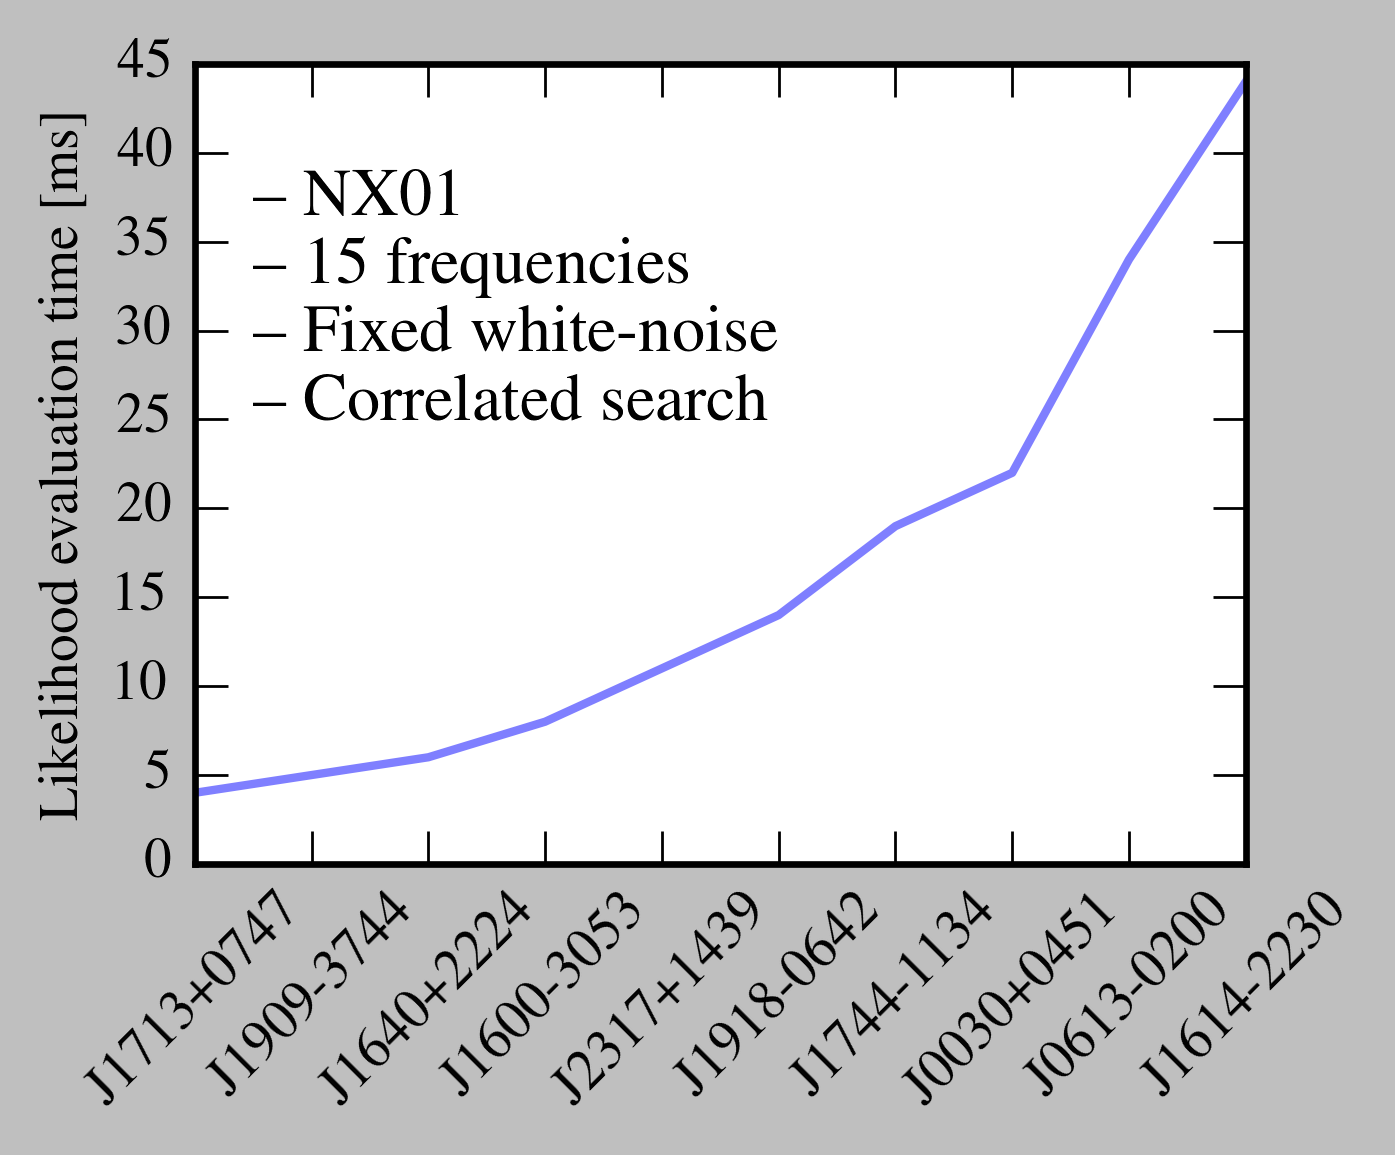

In [323]:
plt.plot(np.double(timings[:,1])/1e-3, lw=1.5, alpha=0.5)
plt.xticks(range(len(timings[:,0])), timings[:,0], rotation=45)

plt.ylabel(r'Likelihood evaluation time [ms]')

plt.text(0.5, 25, '-- NX01\n -- $15$ frequencies\n -- Fixed white-noise\n -- Correlated search', fontsize=12)

plt.savefig('nx01_timings.pdf',bbox_inches='tight')